In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
from ultralytics import YOLO

def focus_main_person_with_segmentation(image_path, blur_strength=55, mask_blur=15, show=True):
    """
    YOLO ile en öndeki kişiyi bulur, MediaPipe ile maskeler.
    Maske kenarları iyileştirilir.
    En öndeki kişi net, diğer kişiler + arka plan bulanık olur.
    
    Args:
        image_path (str): Görsel yolu
        blur_strength (int): Gaussian Blur seviyesi (arka plan için)
        mask_blur (int): Maske kenarlarını yumuşatma seviyesi
        show (bool): True -> matplotlib ile sonucu göster
    """
    # --- 1. YOLO ile kişi tespiti ---
    model = YOLO("yolov8n.pt")  # lightweight model
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    results = model(image)[0]

    person_boxes = []
    for box in results.boxes:
        cls = int(box.cls[0])
        if cls == 0:  # "person"
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            area = (x2 - x1) * (y2 - y1)
            person_boxes.append((area, (x1, y1, x2, y2)))

    if not person_boxes:
        print("Kişi bulunamadı!")
        return image

    # Alanı en büyük olan = en öndeki kişi
    person_boxes.sort(reverse=True, key=lambda x: x[0])
    x1, y1, x2, y2 = person_boxes[0][1]

    # --- 2. MediaPipe ile segmentasyon ---
    mp_selfie_segmentation = mp.solutions.selfie_segmentation
    with mp_selfie_segmentation.SelfieSegmentation(model_selection=1) as selfie_segmentation:
        results = selfie_segmentation.process(image_rgb)
        mask = results.segmentation_mask

        # Sadece bounding box içindeki maskeyi al
        person_mask = np.zeros_like(mask)
        person_mask[y1:y2, x1:x2] = mask[y1:y2, x1:x2]

        # Binary maske (0-1)
        condition = person_mask > 0.5

    # --- 3. Maske iyileştirme ---
    person_mask_uint8 = (condition.astype(np.uint8) * 255)

    # Morfolojik işlemler
    kernel = np.ones((5,5), np.uint8)
    person_mask_uint8 = cv2.morphologyEx(person_mask_uint8, cv2.MORPH_CLOSE, kernel)  # boşlukları kapat
    person_mask_uint8 = cv2.morphologyEx(person_mask_uint8, cv2.MORPH_OPEN, kernel)   # küçük gürültüleri sil

    # Kenarları yumuşatma
    person_mask_uint8 = cv2.GaussianBlur(person_mask_uint8, (mask_blur, mask_blur), 0)

    # 0-1 arası normalize et
    refined_mask = person_mask_uint8.astype(np.float32) / 255.0
    refined_mask = refined_mask[..., None]  # kanal ekle

    # --- 4. Arka planı bulanıklaştır ---
    blurred = cv2.GaussianBlur(image, (blur_strength, blur_strength), 0)
    output = (refined_mask * image + (1 - refined_mask) * blurred).astype(np.uint8)

    # --- 5. Sonucu göster ---
    if show:
        plt.figure(figsize=(15, 6))
        plt.subplot(1, 3, 1)
        plt.title("Orijinal")
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("İyileştirilmiş Maske")
        plt.imshow(refined_mask.squeeze(), cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.title("Odak: En öndeki kişi (iyileştirilmiş)")
        plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()

    return output



0: 448x640 3 persons, 209.4ms
Speed: 7.2ms preprocess, 209.4ms inference, 3.7ms postprocess per image at shape (1, 3, 448, 640)


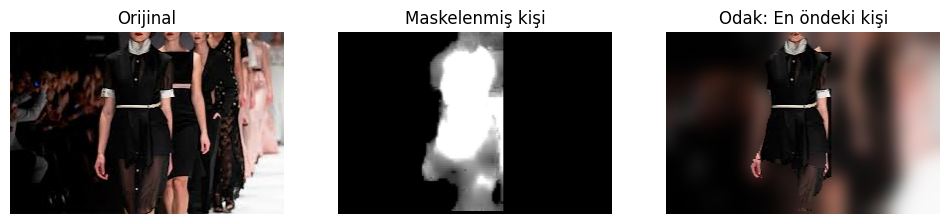

In [8]:
output = focus_main_person_with_segmentation("bircokkisiornek.jpg", blur_strength=55)


0: 384x640 13 persons, 116.4ms
Speed: 3.1ms preprocess, 116.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


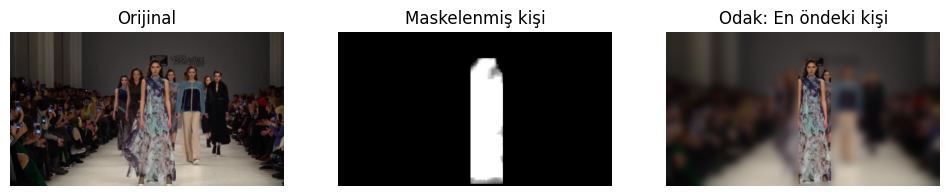

In [9]:
output = focus_main_person_with_segmentation("bircokkisiornek2.jpg", blur_strength=55)